In [1]:
%pip install tensorflow --quiet
%pip install scikit-learn --quiet


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
path = '/Users/anoguera/Documents/GitHub/WasteRecognition-CV'

In [4]:
def load_images_and_labels(base_dir):
    images = []
    labels = []
    folder_to_category = {
        'Cardboard': 'Papel - Cartón',
        'Paper': 'Papel - Cartón',
        'Glass': 'Vidrio - Metal',
        'Metal': 'Vidrio - Metal',
        'Plastic': 'Plastico'
    }
    class_names = list(set(folder_to_category.values()))  # Elimina duplicados y crea la lista de categorías
    class_names.sort()  # Asegúrate de que el orden es correcto
    label_dict = {name: index for index, name in enumerate(class_names)}

    # Iterar sobre los nombres de las carpetas y sus correspondientes categorías
    for folder, category in folder_to_category.items():
        dir_path = os.path.join(base_dir, folder)
        for image_file in os.listdir(dir_path):
            if image_file.lower().endswith('.jpg'):  # Procesar solo archivos JPG
                image_path = os.path.join(dir_path, image_file)
                image = Image.open(image_path).convert("RGB")
                image = ImageOps.fit(image, (224, 224), Image.Resampling.LANCZOS)
                image_array = np.asarray(image)

                # Normalizar la imagen directamente mientras se convierte a float
                normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

                images.append(normalized_image_array)
                labels.append(label_dict[category])

    return np.array(images), np.array(labels), class_names

In [5]:
images, labels, class_names = load_images_and_labels(f'{path}/RealWaste')

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para no modificarlos durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas para la clasificación de basura
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=8)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 175s 553ms/step - accuracy: 0.4873 - loss: 1.1471 - val_accuracy: 0.5719 - val_loss: 0.8938
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 170s 549ms/step - accuracy: 0.6196 - loss: 0.8494 - val_accuracy: 0.5961 - val_loss: 0.8452
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 167s 537ms/step - accuracy: 0.6510 - loss: 0.7617 - val_accuracy: 0.6268 - val_loss: 0.8296
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 167s 539ms/step - accuracy: 0.6573 - loss: 0.7687 - val_accuracy: 0.6042 - val_loss: 0.8508
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 161s 519ms/step - accuracy: 0.6517 - loss: 0.7515 - val_accuracy: 0.5751 - val_loss: 0.9671
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 157s 505ms/step - accuracy: 0.6802 - loss: 0.7456 - val_accuracy: 0.5994 - val_loss: 0.8594
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 156s 504ms/step - accuracy: 0.6756 - loss: 0.7201 - val_accuracy: 0.6430 - val_loss: 0.8275
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 152s 492ms/step - accuracy: 0.6739 -

20/20 - 25s - 1s/step - accuracy: 0.6704 - loss: 1.0798
Test accuracy: 0.6704362034797668


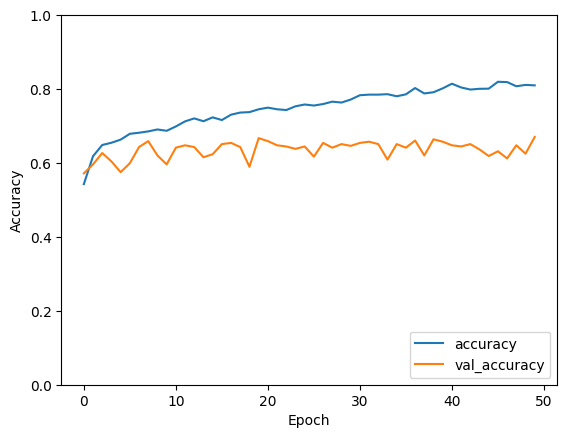

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6385 - loss: 1.1260
Test Loss: 1.07975435256958
Test Accuracy: 0.6704362034797668


In [15]:
y_pred = model.predict(X_test)
# Si las predicciones son probabilísticas (por ejemplo, softmax de salida), obtener la clase predicha como la de mayor probabilidad
y_pred_classes = np.argmax(y_pred, axis=1)  # Esto supone que `model.predict` devuelve un array de probabilidades por clase

20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calcular precisión, recall y f1-score
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calcular la precisión de manera alternativa
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")

                precision    recall  f1-score   support

Papel - Cartón       0.69      0.74      0.72       210
      Plastico       0.60      0.58      0.59       182
Vidrio - Metal       0.71      0.67      0.69       227

      accuracy                           0.67       619
     macro avg       0.67      0.67      0.67       619
  weighted avg       0.67      0.67      0.67       619

Confusion Matrix:
[[156  33  21]
 [ 33 106  43]
 [ 37  37 153]]
Accuracy: 0.6704361873990307


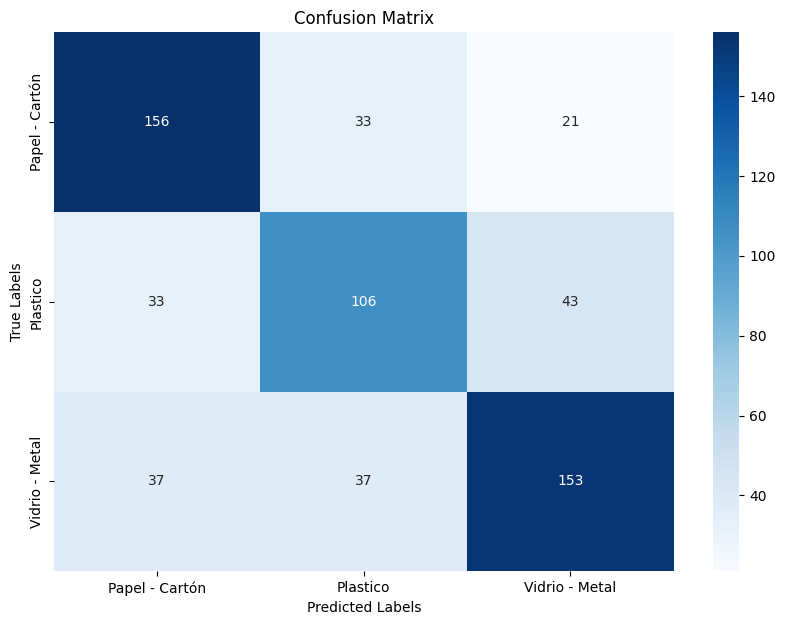

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
X_val, y_val, class_names = load_images_and_labels(f'{path}/Test2')

In [21]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - accuracy: 0.4667 - loss: 3.8704
Test Loss: 3.8703694343566895
Test Accuracy: 0.46666666865348816


In [22]:
y_pred = model.predict(X_val)
# Si las predicciones son probabilísticas (por ejemplo, softmax de salida), obtener la clase predicha como la de mayor probabilidad
y_pred_classes = np.argmax(y_pred, axis=1)  # Esto supone que `model.predict` devuelve un array de probabilidades por clase

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calcular precisión, recall y f1-score
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calcular la precisión de manera alternativa
print(f"Accuracy: {accuracy_score(y_val, y_pred_classes)}")

                precision    recall  f1-score   support

Papel - Cartón       0.42      1.00      0.59         5
      Plastico       0.50      0.20      0.29         5
Vidrio - Metal       1.00      0.20      0.33         5

      accuracy                           0.47        15
     macro avg       0.64      0.47      0.40        15
  weighted avg       0.64      0.47      0.40        15

Confusion Matrix:
[[5 0 0]
 [4 1 0]
 [3 1 1]]
Accuracy: 0.4666666666666667


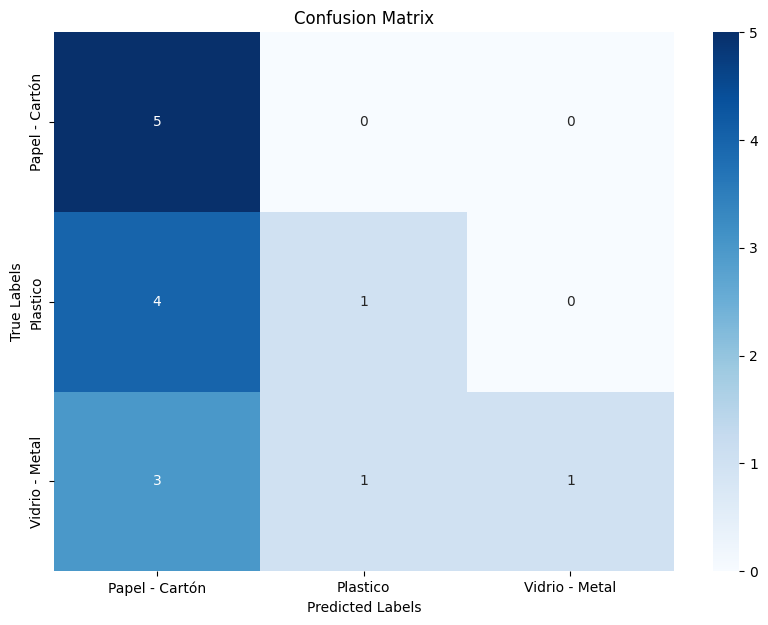

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()